# Superpixel segmentation and texture analysis

In [1]:
import os
import glob
import sys
import fnmatch
from pathlib import Path
import pickle
from itertools import cycle
from functools import partial
import joblib
from math import log10, sqrt, ceil, floor, log, exp, pi, isnan
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=30)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmapy
import tifffile
import pandas as pd
import cv2
from scipy import fftpack
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.signal import convolve2d
import seaborn as sns
from tqdm.notebook import tqdm, trange
from skimage import color
import skimage
import skimage.filters as skf
from skimage.filters import laplace, sobel, sobel_h, sobel_v
import skimage.exposure as ske
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from skimage.transform import rescale
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.filters import threshold_otsu, threshold_yen
from skimage.exposure import rescale_intensity
from skimage.util import view_as_windows
from skimage.feature import canny
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from statannot import add_stat_annotation
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.signal import convolve2d
import multiprocessing as mp
from multiprocessing import Process, Queue, Value, Array, Pool
import umap
import matplotlib.font_manager as fm
%matplotlib inline

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from my_io import display_list_image, read_tiff_files
from texture_analysis_functions import *
from config import *

In [4]:
save_path = f"{data_figure}/texture/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Load the datasets

In [5]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [6]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_UC = pickle.load(open(pickle_name_temp, "rb"))

In [7]:
name_dataset_1 = 'BM'
name_dataset_2 = 'UC'

### Compute texture features

In [8]:
texture_operator_list = [
    energy_laplacian, 
    modified_laplacian,
    diagonal_laplacian,
    variance_laplacian,
    gray_level_variance
]

texture_operators_col = [
    'pixel intensity',
    'mask',
    'energy laplacian',
    'modified laplacian',
    'diagonal laplacian',
    'variance laplacian',
    'gray level variance'
]

texture_operators_names = [
    'Pixel Intensity',
    'Energy Laplacian', 
    'Modified Laplacian', 
    'Diagonal Laplacian', 
    'Variance Laplacian', 
    'Gray Level Variance'
]

texture_operators_col_cluster = [
    'pixel intensity',
    'energy laplacian', 
    'modified laplacian', 
    'diagonal laplacian', 
    'variance laplacian', 
    'gray level variance'
]

nb_operator = len(texture_operator_list)

In [9]:
window_size = 15
pad = window_size // 2
zoomed_texture_list_BM = []

for cell in BM_indices:
    zoomed_texture_list_BM_temp = []  
    for i_count, i in enumerate(idx_channel_names_modif):
        zoomed_image_temp = zoomed_image_list_BM[cell][i]
        zoomed_mask_temp = zoomed_mask_BM[cell]
        M, N = zoomed_image_temp.shape
        zoomed_texture_images = np.zeros((nb_operator + 2, M - window_size + 1, N - window_size + 1))

        for o in range(nb_operator):
            zoomed_texture_images[o+2] = view_as_windows(texture_operator_list[o](zoomed_image_temp), (window_size, window_size), step=1).sum(axis=(2, 3))
        zoomed_texture_images[0] = zoomed_image_temp[pad:M-pad, pad:N-pad]
        zoomed_texture_images[1] = zoomed_mask_temp[pad:M-pad, pad:N-pad]/255
        zoomed_texture_list_BM_temp.append(zoomed_texture_images)
    zoomed_texture_list_BM.append(zoomed_texture_list_BM_temp)

In [10]:
window_size = 15
pad = window_size // 2
zoomed_texture_list_UC = []

for cell in UC_indices:
    zoomed_texture_list_UC_temp = []  
    for i_count, i in enumerate(idx_channel_names_modif):
        zoomed_image_temp = zoomed_image_list_UC[cell][i]
        zoomed_mask_temp = zoomed_mask_UC[cell]
        M, N = zoomed_image_temp.shape
        zoomed_texture_images = np.zeros((nb_operator + 2, M - window_size + 1, N - window_size + 1))

        for o in range(nb_operator):
            zoomed_texture_images[o+2] = view_as_windows(texture_operator_list[o](zoomed_image_temp), (window_size, window_size), step=1).sum(axis=(2, 3))
        zoomed_texture_images[0] = zoomed_image_temp[pad:M-pad, pad:N-pad]
        zoomed_texture_images[1] = zoomed_mask_temp[pad:M-pad, pad:N-pad]/255
        zoomed_texture_list_UC_temp.append(zoomed_texture_images)
    zoomed_texture_list_UC.append(zoomed_texture_list_UC_temp)

In [11]:
def seed_super_pixel(image, mask, num_superpixels=1000, num_levels=15, prior=3, histogram_bins=5, double_step=True):
    
    seeds = cv2.ximgproc.createSuperpixelSEEDS(image.shape[1], image.shape[0], 1, num_superpixels=num_superpixels, num_levels=num_levels, prior=prior, histogram_bins=histogram_bins, double_step=double_step)
    seeds.iterate(image.astype(np.float32),10)
    label_seeds = seeds.getLabels()
    return((label_seeds + 1) * mask)

In [12]:
def slic_super_pixel(image, mask, n_segments=250, compactness=0.001, multichannel=False, slic_zero=True, start_label=1, max_iter=10):

    segments = slic(image, n_segments=n_segments, compactness=compactness, multichannel=multichannel, slic_zero=slic_zero, start_label=start_label, mask=mask, max_iter=max_iter)
    return(segments)

In [13]:
def superpixel_to_texture(image_texture, image_label):
    
    T, M, N = image_texture.shape
    nb_super_pixel = len(np.unique(image_label))
    
    super_pixel_texture_array = np.zeros((T - 1, nb_super_pixel - 1))
    sp_texture_image = np.zeros((T - 1, M, N))
    
    for sp in range(1, nb_super_pixel):
        op = 0
        for t in range(T):
            if t != 1:
                image_texture_temp = image_texture[t]
                super_pixel_texture_array[op, (sp - 1)] = image_texture_temp[np.where(image_label == sp)].mean()
                sp_texture_image[op][image_label == sp] = image_texture_temp[np.where(image_label == sp)].mean()
                op += 1
    return(super_pixel_texture_array, sp_texture_image)

### Clustering

In [14]:
df_texture_sp = pd.DataFrame(columns=texture_operators_names + ['cell_type', 'cell', 'marker'])
n_segments = 250

for i in trange(len(zoomed_texture_list_BM)):
    image_temp = zoomed_texture_list_BM[i][0][0]+zoomed_texture_list_BM[i][1][0]+zoomed_texture_list_BM[i][2][0]+zoomed_texture_list_BM[i][3][0]+zoomed_texture_list_BM[i][4][0]
    mask_temp = zoomed_texture_list_BM[i][0][1]
    df_texture_sp_temp_atf6 = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_BM[i][0], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_atf6['marker'] = 'ATF6'
    df_texture_sp_temp_dapi = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_BM[i][1], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_dapi['marker'] = 'DAPI'
    df_texture_sp_temp_golph4 = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_BM[i][2], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_golph4['marker'] = 'GOLPH4'
    df_texture_sp_temp_nucleolin = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_BM[i][3], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_nucleolin['marker'] = 'Nucleolin'
    df_texture_sp_temp_tom20 = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_BM[i][4], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_tom20['marker'] = 'TOM20'
    df_texture_sp_temp = pd.concat([df_texture_sp_temp_atf6, df_texture_sp_temp_dapi, df_texture_sp_temp_golph4, df_texture_sp_temp_nucleolin, df_texture_sp_temp_tom20])
    df_texture_sp_temp['cell_type'] = name_dataset_1
    df_texture_sp_temp['cell'] = i
    df_texture_sp = pd.concat([df_texture_sp, df_texture_sp_temp])

for i in trange(len(zoomed_texture_list_UC)):
    image_temp = zoomed_texture_list_UC[i][0][0]+zoomed_texture_list_UC[i][1][0]+zoomed_texture_list_UC[i][2][0]+zoomed_texture_list_UC[i][3][0]+zoomed_texture_list_UC[i][4][0]
    mask_temp = zoomed_texture_list_UC[i][0][1]
    df_texture_sp_temp_atf6 = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_UC[i][0], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_atf6['marker'] = 'ATF6'
    df_texture_sp_temp_dapi = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_UC[i][1], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_dapi['marker'] = 'DAPI'
    df_texture_sp_temp_golph4 = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_UC[i][2], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_golph4['marker'] = 'GOLPH4'
    df_texture_sp_temp_nucleolin = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_UC[i][3], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_nucleolin['marker'] = 'Nucleolin'
    df_texture_sp_temp_tom20 = pd.DataFrame(superpixel_to_texture(zoomed_texture_list_UC[i][4], slic_super_pixel(image_temp, mask_temp, n_segments=n_segments))[0].T, columns=texture_operators_names)
    df_texture_sp_temp_tom20['marker'] = 'TOM20'
    df_texture_sp_temp = pd.concat([df_texture_sp_temp_atf6, df_texture_sp_temp_dapi, df_texture_sp_temp_golph4, df_texture_sp_temp_nucleolin, df_texture_sp_temp_tom20])
    df_texture_sp_temp['cell_type'] = name_dataset_2
    df_texture_sp_temp['cell'] = i
    df_texture_sp = pd.concat([df_texture_sp, df_texture_sp_temp])

df_texture_sp.reset_index(inplace=True, drop=True)
del df_texture_sp_temp

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
df_texture_sp

,Pixel Intensity,Energy Laplacian,Modified Laplacian,Diagonal Laplacian,Variance Laplacian,Gray Level Variance,cell_type,cell,marker
0,0.857960,2340.094147,353.785317,688.116198,2340.094147,9349.609639,BM,0,ATF6
1,2.383470,9589.554132,1262.900391,2382.152688,9589.554132,6066.709311,BM,0,ATF6
2,1.293601,5470.538577,764.892140,1452.206834,5470.538577,7967.489743,BM,0,ATF6
3,2.535778,10268.287741,1289.029840,2423.467920,10268.287741,6024.058755,BM,0,ATF6
4,0.007470,2364.408601,351.616260,684.399440,2364.408601,9473.407826,BM,0,ATF6
...,...,...,...,...,...,...,...,...,...
14700,1.848151,3463.393581,740.284452,1436.210041,3463.393581,1204.388541,UC,6,TOM20
14701,2.645154,6554.365291,1059.460286,2001.189763,6554.365291,1071.866974,UC,6,TOM20
14702,1.502646,5175.607585,888.620003,1670.599458,5175.607585,1513.413580,UC,6,TOM20
14703,1.950652,5984.005866,981.786675,1824.295484,5984.005866,1385.069595,UC,6,TOM20


In [16]:
scaler_sp = StandardScaler() 
df_texture_scaled_sp = pd.DataFrame(scaler_sp.fit_transform(df_texture_sp[texture_operators_names]), columns=texture_operators_names)
df_texture_scaled_sp = pd.concat([df_texture_scaled_sp, df_texture_sp[['cell_type', 'cell', 'marker']]], axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\mvenkatesan7\AppData\Local\Continuum\anaconda3\envs\ParcEnv\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


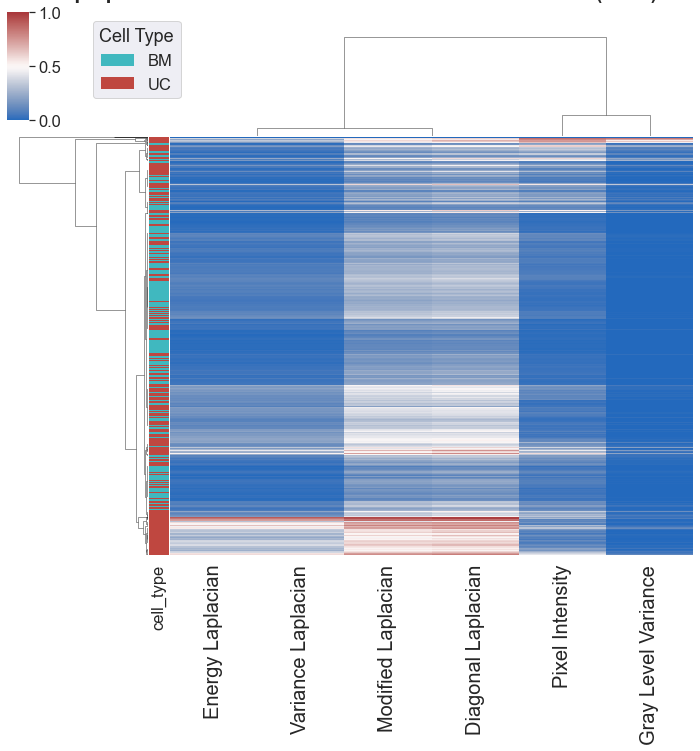

In [17]:
df_atf6 = df_texture_scaled_sp[df_texture_scaled_sp['marker']=='ATF6']

metric_list = [
    'correlation',
]

sns.set(font_scale = 1.5)

cell_type_label = df_texture_scaled_sp.cell_type
cell_type_label.to_list()

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)
    
for metric_temp in tqdm(metric_list):
    g=sns.clustermap(df_atf6[texture_operators_names], row_colors=row_colors1, yticklabels=False, 
                     cbar_pos=(.02, .85, .03, .15), standard_scale=1, metric=metric_temp, cmap='vlag')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
    for label in cell_type_label.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper center", ncol=1, bbox_to_anchor=(0.2, 1), bbox_transform=plt.gcf().transFigure)

    g.fig.suptitle(f"Superpixel Texture clustered with the {metric_temp} method (ATF6)", x=0.5, y=1.04, fontsize=20, fontweight='bold')
    g.savefig(f"{save_path}/super_pixel_texture_metric_atf6_{metric_temp}_{n_segments}.png", bbox_inches="tight")
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

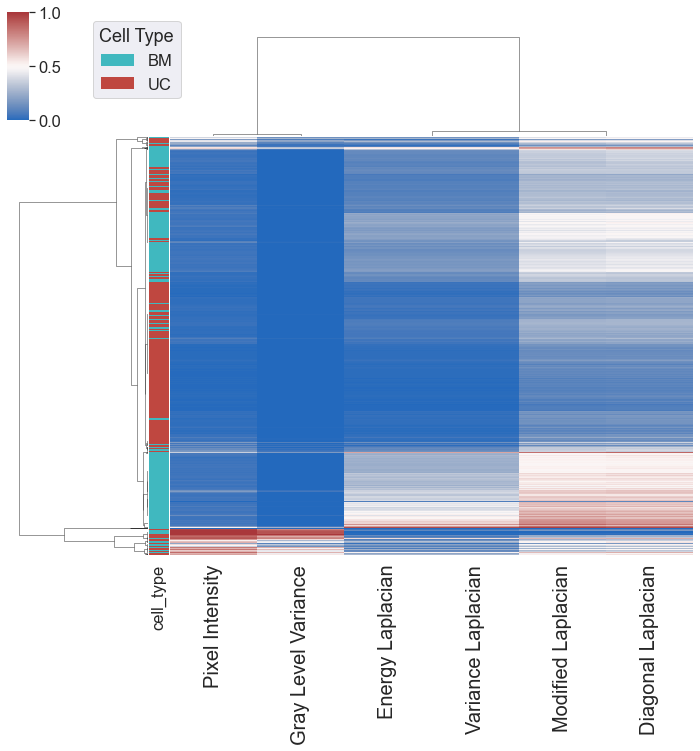

In [18]:
df_dapi = df_texture_scaled_sp[df_texture_scaled_sp['marker']=='DAPI']


metric_list = [
    'correlation',
]

sns.set(font_scale = 1.5)

cell_type_label = df_texture_scaled_sp.cell_type
cell_type_label.to_list()

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)
    
for metric_temp in tqdm(metric_list):
    g=sns.clustermap(df_dapi[texture_operators_names], row_colors=row_colors1, yticklabels=False, 
                     cbar_pos=(.02, .85, .03, .15), standard_scale=1, metric=metric_temp, cmap='vlag')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
    for label in cell_type_label.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper center", ncol=1, bbox_to_anchor=(0.2, 1), bbox_transform=plt.gcf().transFigure)

    g.fig.suptitle(f"Superpixel Texture clustered with the {metric_temp} method (DAPI)", x=0.5, y=1.05, fontsize=20, fontweight='bold')
    g.savefig(f"{save_path}/super_pixel_texture_metric_dapi_{metric_temp}_{n_segments}.png", bbox_inches="tight")
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

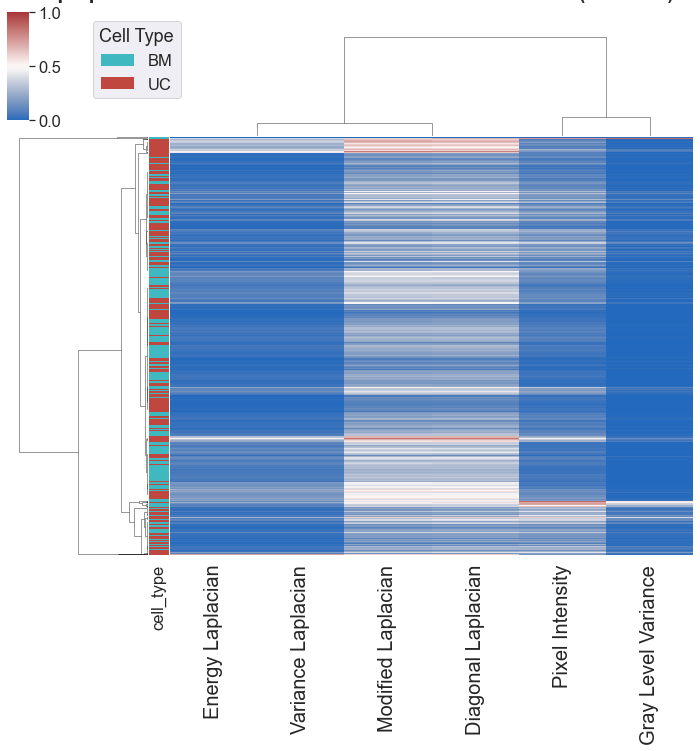

In [19]:
df_golph4 = df_texture_scaled_sp[df_texture_scaled_sp['marker']=='GOLPH4']


metric_list = [
    'correlation',
]

sns.set(font_scale = 1.5)

cell_type_label = df_texture_scaled_sp.cell_type
cell_type_label.to_list()

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)
    
for metric_temp in tqdm(metric_list):
    g=sns.clustermap(df_golph4[texture_operators_names], row_colors=row_colors1, yticklabels=False, 
                     cbar_pos=(.02, .85, .03, .15), standard_scale=1, metric=metric_temp, cmap='vlag')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
    for label in cell_type_label.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper center", ncol=1, bbox_to_anchor=(0.2, 1), bbox_transform=plt.gcf().transFigure)

    g.fig.suptitle(f"Superpixel Texture clustered with the {metric_temp} method (GOLPH4)", x=0.5, y=1.04, fontsize=20, fontweight='bold')
    g.savefig(f"{save_path}/super_pixel_texture_metric_golph4_{metric_temp}_{n_segments}.png", bbox_inches="tight")
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

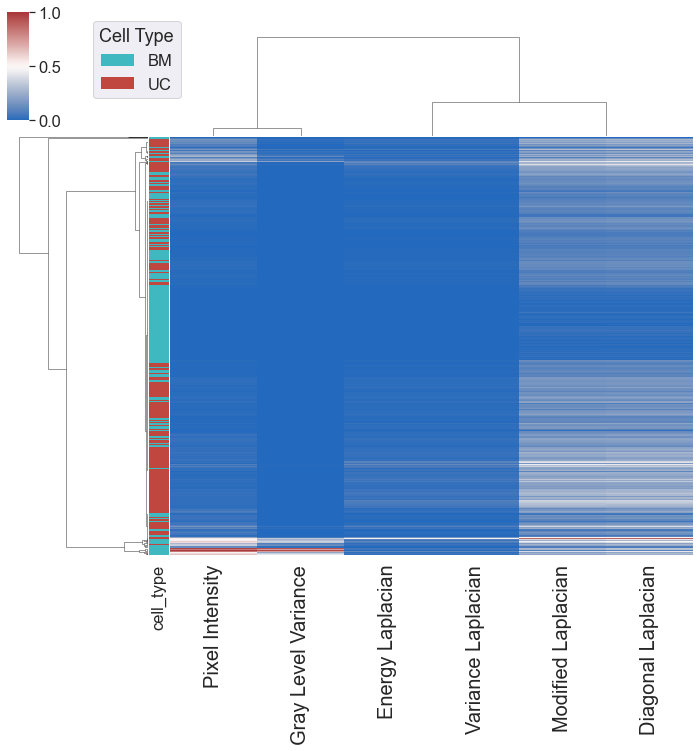

In [20]:
df_nucleolin = df_texture_scaled_sp[df_texture_scaled_sp['marker']=='Nucleolin']

metric_list = [
    'correlation',
]

sns.set(font_scale = 1.5)

cell_type_label = df_texture_scaled_sp.cell_type
cell_type_label.to_list()

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    g=sns.clustermap(df_nucleolin[texture_operators_names], row_colors=row_colors1, yticklabels=False, 
                     cbar_pos=(.02, .85, .03, .15), standard_scale=1, metric=metric_temp, cmap='vlag')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
    for label in cell_type_label.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper center", ncol=1, bbox_to_anchor=(0.2, 1), bbox_transform=plt.gcf().transFigure)

    g.fig.suptitle(f"Superpixel Texture (Nucleolin)", x=0.5, y=1.05, fontsize=20, fontweight='bold')
    g.savefig(f"{save_path}/super_pixel_texture_metric_nucleolin_{metric_temp}_{n_segments}.png", bbox_inches="tight")
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

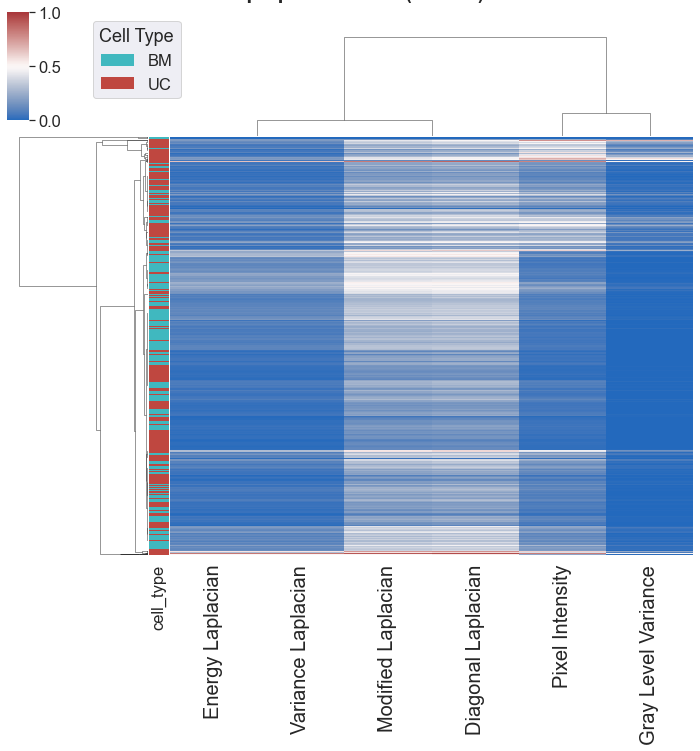

In [21]:
df_tom20 = df_texture_scaled_sp[df_texture_scaled_sp['marker']=='TOM20']

metric_list = [
    'correlation',
]

sns.set(font_scale = 1.5)

cell_type_label = df_texture_scaled_sp.cell_type
cell_type_label.to_list()

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    g=sns.clustermap(df_tom20[texture_operators_names], row_colors=row_colors1, yticklabels=False, 
                     cbar_pos=(.02, .85, .03, .15), standard_scale=1, metric=metric_temp, cmap='vlag')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
    for label in cell_type_label.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper center", ncol=1, bbox_to_anchor=(0.2, 1), bbox_transform=plt.gcf().transFigure)

    g.fig.suptitle(f"Superpixel Texture (TOM20)", x=0.5, y=1.04, fontsize=20, fontweight='bold')
    g.savefig(f"{save_path}/super_pixel_texture_metric_tom20_{metric_temp}_{n_segments}.png", bbox_inches="tight")
    plt.show()

### Plot Superpixel example

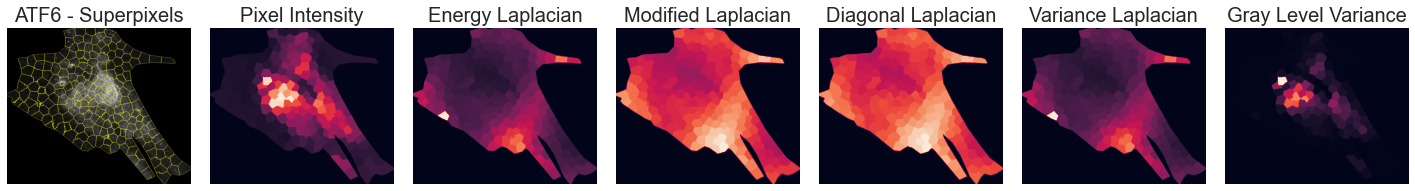

In [22]:
sns.set_style("dark")
plt.style.use('seaborn-paper')

idx_chan = 0
cell_idx = 1
n_segments = 250

chan_name = channel_names_modif[idx_chan]
image_sp_plot = zoomed_texture_list_BM[cell_idx][0][0]+zoomed_texture_list_BM[cell_idx][1][0]+zoomed_texture_list_BM[cell_idx][2][0]+zoomed_texture_list_BM[cell_idx][3][0]+zoomed_texture_list_BM[cell_idx][4][0]
mask_sp = zoomed_texture_list_BM[cell_idx][idx_chan][1].copy()
segments = slic_super_pixel(image_sp_plot, mask_sp, n_segments=n_segments)

texture_array = zoomed_texture_list_BM[cell_idx][idx_chan].copy()
_, texture_image = superpixel_to_texture(texture_array, segments)

image_list = [mark_boundaries((image_sp_plot).astype(np.uint8), segments)] + [texture_image[i] for i in range(texture_image.shape[0])]
image_name_list = [f"{chan_name} - Superpixels"] + texture_operators_names

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i, ax in zip(range(len(image_list)), axes.flatten()):
    ax.imshow(image_list[i])
    ax.set_title(image_name_list[i], fontdict={'fontsize': 20, 'fontweight' : 'medium'})
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(f"{save_path}/super_pixel_atf6.png", bbox_inches="tight")
plt.show()

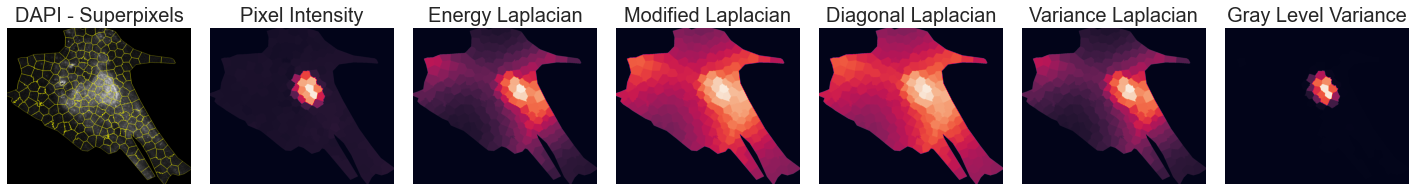

In [23]:
sns.set_style("dark")
plt.style.use('seaborn-paper')

idx_chan = 1
cell_idx = 1
n_segments = 250

chan_name = channel_names_modif[idx_chan]
image_sp_plot = zoomed_texture_list_BM[cell_idx][0][0]+zoomed_texture_list_BM[cell_idx][1][0]+zoomed_texture_list_BM[cell_idx][2][0]+zoomed_texture_list_BM[cell_idx][3][0]+zoomed_texture_list_BM[cell_idx][4][0]
mask_sp = zoomed_texture_list_BM[cell_idx][idx_chan][1].copy()
segments = slic_super_pixel(image_sp_plot, mask_sp, n_segments=n_segments)

texture_array = zoomed_texture_list_BM[cell_idx][idx_chan].copy()
_, texture_image = superpixel_to_texture(texture_array, segments)

image_list = [mark_boundaries((image_sp_plot).astype(np.uint8), segments)] + [texture_image[i] for i in range(texture_image.shape[0])]
image_name_list = [f"{chan_name} - Superpixels"] + texture_operators_names

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i, ax in zip(range(len(image_list)), axes.flatten()):
    ax.imshow(image_list[i])
    ax.set_title(image_name_list[i], fontdict={'fontsize': 20, 'fontweight' : 'medium'})
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(f"{save_path}/super_pixel_dapi.png", bbox_inches="tight")
plt.show()

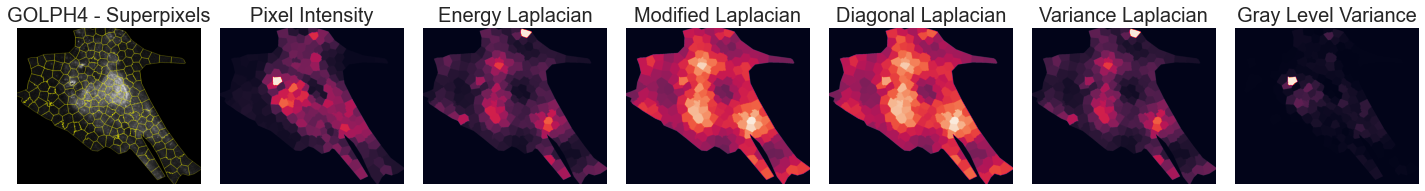

In [24]:
sns.set_style("dark")
plt.style.use('seaborn-paper')

idx_chan = 2
cell_idx = 1
n_segments = 250

chan_name = channel_names_modif[idx_chan]
image_sp_plot = zoomed_texture_list_BM[cell_idx][0][0]+zoomed_texture_list_BM[cell_idx][1][0]+zoomed_texture_list_BM[cell_idx][2][0]+zoomed_texture_list_BM[cell_idx][3][0]+zoomed_texture_list_BM[cell_idx][4][0]
mask_sp = zoomed_texture_list_BM[cell_idx][idx_chan][1].copy()
segments = slic_super_pixel(image_sp_plot, mask_sp, n_segments=n_segments)

texture_array = zoomed_texture_list_BM[cell_idx][idx_chan].copy()
_, texture_image = superpixel_to_texture(texture_array, segments)

image_list = [mark_boundaries((image_sp_plot).astype(np.uint8), segments)] + [texture_image[i] for i in range(texture_image.shape[0])]
image_name_list = [f"{chan_name} - Superpixels"] + texture_operators_names

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i, ax in zip(range(len(image_list)), axes.flatten()):
    ax.imshow(image_list[i])
    ax.set_title(image_name_list[i], fontdict={'fontsize': 20, 'fontweight' : 'medium'})
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(f"{save_path}/super_pixel_golph4.png", bbox_inches="tight")
plt.show()

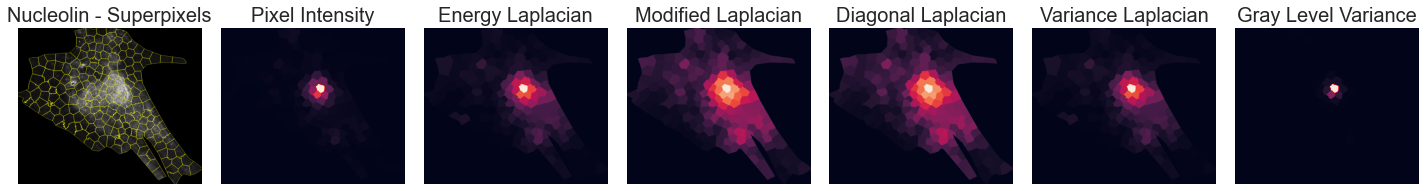

In [25]:
sns.set_style("dark")
plt.style.use('seaborn-paper')

idx_chan = 3
cell_idx = 1
n_segments = 250

chan_name = channel_names_modif[idx_chan]
image_sp_plot = zoomed_texture_list_BM[cell_idx][0][0]+zoomed_texture_list_BM[cell_idx][1][0]+zoomed_texture_list_BM[cell_idx][2][0]+zoomed_texture_list_BM[cell_idx][3][0]+zoomed_texture_list_BM[cell_idx][4][0]
mask_sp = zoomed_texture_list_BM[cell_idx][idx_chan][1].copy()
segments = slic_super_pixel(image_sp_plot, mask_sp, n_segments=n_segments)

texture_array = zoomed_texture_list_BM[cell_idx][idx_chan].copy()
_, texture_image = superpixel_to_texture(texture_array, segments)

image_list = [mark_boundaries((image_sp_plot).astype(np.uint8), segments)] + [texture_image[i] for i in range(texture_image.shape[0])]
image_name_list = [f"{chan_name} - Superpixels"] + texture_operators_names

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i, ax in zip(range(len(image_list)), axes.flatten()):
    ax.imshow(image_list[i])
    ax.set_title(image_name_list[i], fontdict={'fontsize': 20, 'fontweight' : 'medium'})
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(f"{save_path}/super_pixel_nucleolin.png", bbox_inches="tight")
plt.show()

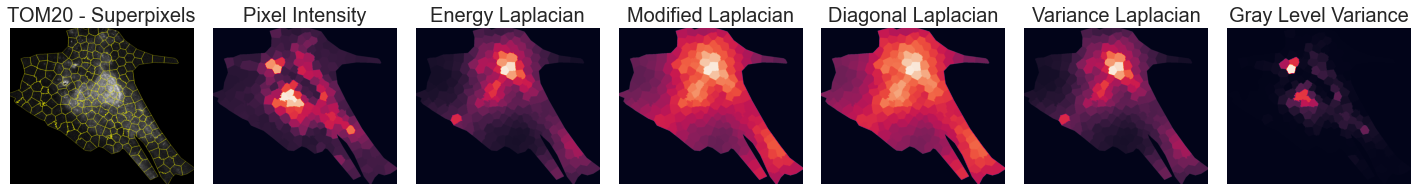

In [26]:
sns.set_style("dark")
plt.style.use('seaborn-paper')

idx_chan = 4
cell_idx = 1
n_segments = 250

chan_name = channel_names_modif[idx_chan]
image_sp_plot = zoomed_texture_list_BM[cell_idx][0][0]+zoomed_texture_list_BM[cell_idx][1][0]+zoomed_texture_list_BM[cell_idx][2][0]+zoomed_texture_list_BM[cell_idx][3][0]+zoomed_texture_list_BM[cell_idx][4][0]
mask_sp = zoomed_texture_list_BM[cell_idx][idx_chan][1].copy()
segments = slic_super_pixel(image_sp_plot, mask_sp, n_segments=n_segments)

texture_array = zoomed_texture_list_BM[cell_idx][idx_chan].copy()
_, texture_image = superpixel_to_texture(texture_array, segments)

image_list = [mark_boundaries((image_sp_plot).astype(np.uint8), segments)] + [texture_image[i] for i in range(texture_image.shape[0])]
image_name_list = [f"{chan_name} - Superpixels"] + texture_operators_names

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i, ax in zip(range(len(image_list)), axes.flatten()):
    ax.imshow(image_list[i])
    ax.set_title(image_name_list[i], fontdict={'fontsize': 20, 'fontweight' : 'medium'})
    ax.set_axis_off()

plt.tight_layout()
plt.savefig(f"{save_path}/super_pixel_tom20.png", bbox_inches="tight")
plt.show()